# Применение классификатора к картинке

Дано:
- обученный классификатор
- произвольная картинка

Найти:
- классифицировать каждый шестиугольник либо как фишку, либо как мусор
- поместить метку на картинку рядом с шестиугольником

In [72]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from model import VGG

from glob import glob
import cv2

from scipy.stats import entropy
from collections import defaultdict
import matplotlib.pyplot as plt

from hexagon_extraction import get_hexagons

## Load Model

In [2]:
model = VGG()
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Load Images

In [11]:
dir_path = 'images/'
files = glob(dir_path + '*.bmp')
images = {}
for file in files:
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    images[file[7:-4]] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Get Hexagons and Their Centers

In [4]:
detected, centers = get_hexagons(dir_path='images/', output_shape=(16,16), start=7, end=-4)

In [5]:
detected.keys()

dict_keys(['Path_5', 'Single_8', 'Single_7', 'Single_9', 'Dozen_0', 'Path_6', 'Group_3', 'Single_0', 'Single_4', 'Single_6', 'Group_5', 'Group_4', 'Single_3', 'Group_6', 'Group_1', 'Single_1', 'Single_2', 'Path_9', 'Single_5', 'Group_2', 'Path_7'])

## Feed to Net

In [106]:
with torch.no_grad():
    tagged = defaultdict(list)
    for key, hexagons in detected.items():
        # image to put labels to
        tagged[key] = images[key].copy()
        
        # make one batch of images
        shape = hexagons[0].shape
        batch = torch.empty((len(hexagons), shape[2], shape[0], shape[1]))
        for i, hex in enumerate(hexagons):
            hex = T.functional.to_tensor(cv2.GaussianBlur(hex.astype(float), (3,3), 0.5))
            batch[i] = hex.float()
        
        # forward pass
        logits = model(batch)
        
        # get probabilities
        probs = F.softmax(logits.detach(), dim=1).cpu()
        
        # filter non chips
        for prob, center in zip(probs, centers[key]):
            pred = prob.argmax().item()+1
            ent = entropy(prob)
            if ent > 0.5 or pred == 11:
                continue
            cv2.putText(tagged[key], str(pred), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4)

In [110]:
def imshow(prefix, src, use_colors=False, figname=None):
    keys = [key for key in src.keys() if key.startswith(prefix)]
    n = len(keys)
    _, ax = plt.subplots(1, n, figsize=(n*6, 12))
    for i, key in enumerate(keys):
        if use_colors:
            ax[i].imshow(src[key])
        else:
            ax[i].imshow(src[key], cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(key)
    if figname is not None:
        plt.savefig(figname + '.svg')

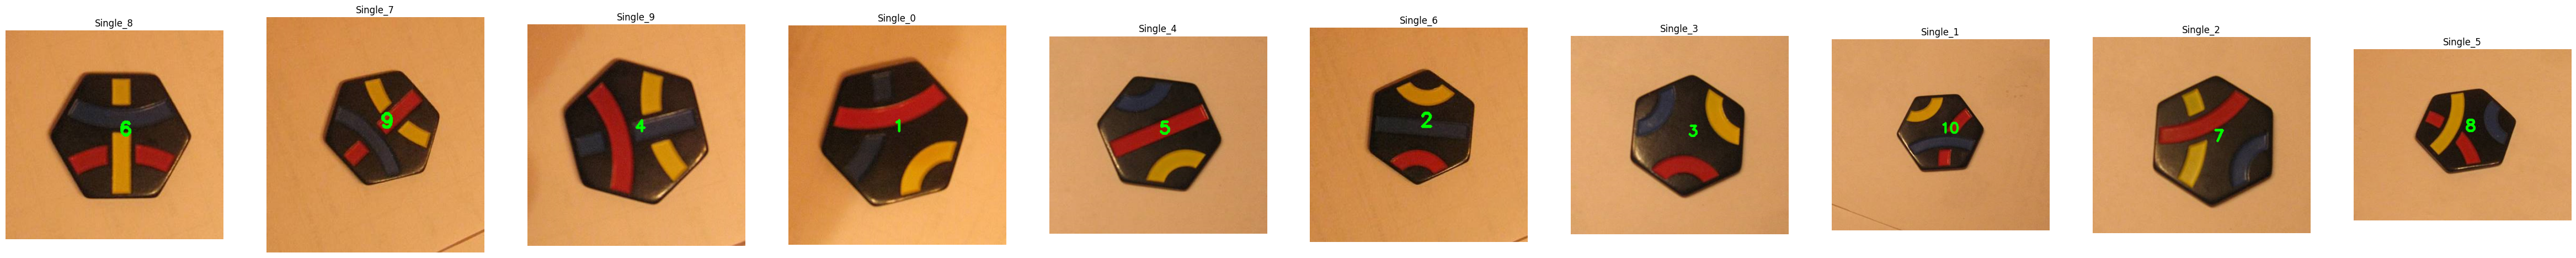

In [111]:
imshow('Single', tagged)